In [16]:
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import seaborn as sns
import nltk
import difflib
from sklearn.decomposition import LatentDirichletAllocation
import time


pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [3]:
def show_card(name=None,show=False):
    if name is None:
        card_name = input('Enter the name of a commander: ').strip()
        if card_name.lower()=='exit':
            return
    else:
        card_name = name
    try:
        card = commanders[commanders.index.str.lower()==card_name.lower()]
        response = requests.get(card.image_uris.tolist()[0]['normal'])
    except:
        closest = difflib.get_close_matches(card_name,commanders.index.tolist(),len(commanders.index.tolist()),0)[0]
        print(f"Could not find {card_name}. Instead showing {closest}.")
        card = commanders[commanders.index==closest]
        response = requests.get(card.image_uris.tolist()[0]['normal'])
    img = Image.open(BytesIO(response.content))
    if show==True:
        display(img)
    return card.image_uris.tolist()[0]['normal']

# Load cards and drop columns

In [6]:
commanders = pd.read_json('Data/commander_legal.json')

In [7]:
commanders.columns

Index(['all_parts', 'artist', 'cmc', 'color_identity', 'color_indicator',
       'colors', 'edhrec_rank', 'games', 'highres_image', 'image_uris', 'lang',
       'layout', 'legalities', 'loyalty', 'mana_cost', 'name', 'oracle_text',
       'oversized', 'power', 'preview', 'printed_text', 'printed_type_line',
       'promo', 'released_at', 'reprint', 'reserved', 'scryfall_uri', 'set',
       'set_name', 'set_search_uri', 'tcgplayer_id', 'textless', 'toughness',
       'type_line', 'pop_cmdr', 'w', 'u', 'b', 'r', 'g', 'wu', 'ub', 'br',
       'rg', 'gw', 'wb', 'ur', 'bg', 'rw', 'gu', 'wub', 'ubr', 'brg', 'rgw',
       'gwu', 'wbg', 'urw', 'bgu', 'rwb', 'gur', 'wubr', 'ubrg', 'brgw',
       'rgwu', 'gwub', 'wubrg', 'colorless'],
      dtype='object')

**Only include legendary creatures with a normal layout and no partner mechanic**

In [8]:
commanders = commanders[commanders.type_line.str.contains('Legendary Creature')]

In [9]:
commanders = commanders[commanders.layout=='normal']

In [10]:
commanders = commanders[~commanders.oracle_text.str.contains('Partner')]

**Dataset includes reprints as a separate row, so drop those to have a unique list**

In [11]:
commanders.drop_duplicates('name','last',inplace=True)

**Set the index of my DataFrame to the card name**

In [12]:
commanders.set_index('name',inplace=True)

In [13]:
commanders.head()

all_parts               artist  cmc color_identity  \
name                                                                            
Ink-Eyes, Servant of Oni        None       Wayne Reynolds    6            [B]   
Higure, the Still Wind          None  Christopher Moeller    5            [U]   
Zedruu the Greathearted         None             Mark Zug    4      [R, U, W]   
Sydri, Galvanic Genius          None       Terese Nielsen    3      [B, U, W]   
Selvala, Explorer Returned      None       Tyler Jacobson    3         [G, W]   

                           color_indicator     colors  edhrec_rank  games  \
name                                                                        
Ink-Eyes, Servant of Oni              None        [B]       1759.0   True   
Higure, the Still Wind                None        [U]       2866.0   True   
Zedruu the Greathearted               None  [R, U, W]       3048.0   True   
Sydri, Galvanic Genius                None  [B, U, W]       2767.0   True   
Selvala, Explorer Returned            None     [G, W]       1198.0   True   

                            highres_image  \
name                                        
Ink-Eyes, Servant of Oni             True   
Higure, the Still Wind               True   
Zedruu the Greathearted              True   
Sydri, Galvanic Genius               True   
Selvala, Explorer Returned           True   

                                                                   image_uris  \
name                                                                            
Ink-Eyes, Servant of Oni    {'small': 'https://img.scryfall.com/cards/smal...   
Higure, the Still Wind      {'small': 'https://img.scryfall.com/cards/smal...   
Zedruu the Greathearted     {'small': 'https://img.scryfall.com/cards/smal...   
Sydri, Galvanic Genius      {'small': 'https://img.scryfall.com/cards/smal...   
Selvala, Explorer Returned  {'small': 'https://img.scryfall.com/cards/smal...   

                           lang  layout legalities loyalty     mana_cost  \
name                                                                       
Ink-Eyes, Servant of Oni     en  normal      legal    None     {4}{B}{B}   
Higure, the Still Wind       en  normal      legal    None     {3}{U}{U}   
Zedruu the Greathearted      en  normal      legal    None  {1}{U}{R}{W}   
Sydri, Galvanic Genius       en  normal      legal    None     {W}{U}{B}   
Selvala, Explorer Returned   en  normal      legal    None     {1}{G}{W}   

                                                                  oracle_text  \
name                                                                            
Ink-Eyes, Servant of Oni    Ninjutsu {3}{B}{B} ({3}{B}{B}, Return an unblo...   
Higure, the Still Wind      Ninjutsu {2}{U}{U} ({2}{U}{U}, Return an unblo...   
Zedruu the Greathearted     At the beginning of your upkeep, you gain X li...   
Sydri, Galvanic Genius      {U}: Target noncreature artifact becomes an ar...   
Selvala, Explorer Returned  Parley — {T}: Each player reveals the top card...   

                            oversized power preview  printed_text  \
name                                                                
Ink-Eyes, Servant of Oni        False     5    None           NaN   
Higure, the Still Wind          False     3    None           NaN   
Zedruu the Greathearted         False     2    None           NaN   
Sydri, Galvanic Genius          False     2    None           NaN   
Selvala, Explorer Returned      False     2    None           NaN   

                            printed_type_line  promo released_at  reprint  \
name                                                                        
Ink-Eyes, Servant of Oni                  NaN  False  2016-11-25     True   
Higure, the Still Wind                    NaN  False  2016-11-25     True   
Zedruu the Greathearted                   NaN  False  2016-11-11     True   
Sydri, Galvanic Genius                    NaN  False  2016-11-11 

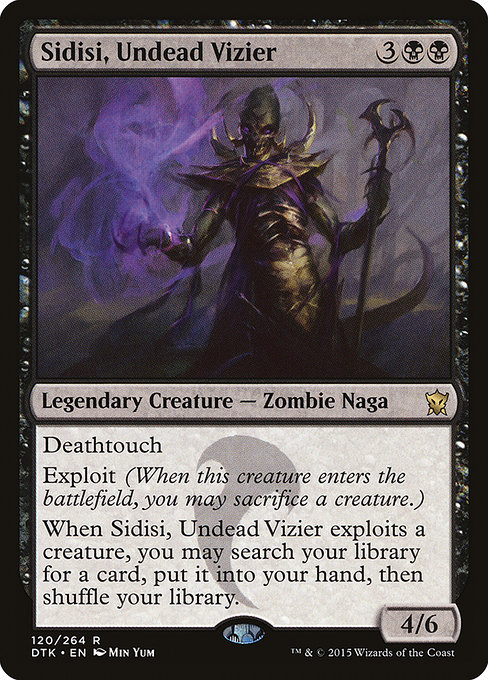

'https://img.scryfall.com/cards/normal/front/6/e/6ea5dbba-6114-4d97-9363-817ab9e896d3.jpg?1562788006'

In [14]:
show_card(commanders.sort_values('edhrec_rank').iloc[0].head().name,True)

## LDA to find topics of commanders

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords

**Stopwords started with standard english stopwords and the names of the cards. Other keywords were added manually after trial and error to see which words were appearing in too many topics at once**

In [13]:
stop = list(set(stopwords.words('english')))
names = [card_name.lower().replace(',','').split() for card_name in commanders.index]
for name in names:
    stop.extend(name)
stop += ['gain','give','each','among','least','less','choice','until','end','start','beginning','upkeep','may',
         'put','under','whenever','except','player','cost','turn','gets','get','pay','deals','control',
         'controls','color','order','lose','battlefield','target','spell','card','equal','ability','activate',
         'next','step','cast','owner','time','would','instead','number','onto','though','long',
         'choose','converted','mana','permanent','another','card','cards','horsemanship','flying','creature',
         'creatures','opponents','countered','divinity', 'divinity counter', 'enters opponent', 'equipment',
         'experience', 'name', 'type', 'vampire','create','creates','trample','reach','lifelink','first',
         'double','haste','strike','white','blue','black','red','green','becomes','all','vigilance','unless',
         'blocked','tap','tapped','untap','gains','reveal','return','add', 'opponent','enters','power','toughness']
stop = list(set(stop))

# Make a corpa of individual text lines of all card for training

In [14]:
all_cards = pd.read_json('Data/commander_legal.json')
all_text = [text.strip().lower().split('\n') for text in commanders.oracle_text]
temp = []
for text in all_text:
    temp.extend(text)
all_text = temp
all_tf_vectorizer = CountVectorizer(max_df=0.9, min_df=10,stop_words=stop, analyzer='word',ngram_range=(1,2))
all_tf = all_tf_vectorizer.fit_transform(all_text)
all_tf_feature_names = all_tf_vectorizer.get_feature_names()

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ancestor', 'arms', 'ben', 'blossom', 'boar', 'cho', 'clad', 'corpse', 'counter', 'dal', 'devouring', 'dûl', 'eight', 'eye', 'eyed', 'gilt', 'gitaxias', 'glass', 'gnawer', 'gold', 'half', 'heron', 'ihsan', 'il', 'ink', 'ishi', 'jiki', 'kagachi', 'kanar', 'kiki', 'kin', 'kuar', 'lim', 'manno', 'maro', 'marrow', 'mizzet', 'mors', 'nature', 'nephalia', 'night', 'niv', 'opal', 'palladia', 'phoenix', 'praetors', 'raze', 'rrik', 'sanity', 'scar', 'seasons', 'sek', 'selesnya', 'ship', 'shizo', 'sleeping', 'sol', 'spinner', 'striped', 'tail', 'tails', 'thousand', 'ur', 'yavimaya', 'zo', 'zu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# Make a corpa of legendary creature full card texts to predict on

In [15]:
texts = [text.strip().lower().replace('\n',' ') for text in commanders.oracle_text]

In [16]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=10,stop_words=stop, analyzer='word',ngram_range=(1,2)) # max_df=0.95, min_df=10,
tf = tf_vectorizer.fit_transform(texts)
tf_feature_names = tf_vectorizer.get_feature_names()

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ancestor', 'arms', 'ben', 'blossom', 'boar', 'cho', 'clad', 'corpse', 'counter', 'dal', 'devouring', 'dûl', 'eight', 'eye', 'eyed', 'gilt', 'gitaxias', 'glass', 'gnawer', 'gold', 'half', 'heron', 'ihsan', 'il', 'ink', 'ishi', 'jiki', 'kagachi', 'kanar', 'kiki', 'kin', 'kuar', 'lim', 'manno', 'maro', 'marrow', 'mizzet', 'mors', 'nature', 'nephalia', 'night', 'niv', 'opal', 'palladia', 'phoenix', 'praetors', 'raze', 'rrik', 'sanity', 'scar', 'seasons', 'sek', 'selesnya', 'ship', 'shizo', 'sleeping', 'sol', 'spinner', 'striped', 'tail', 'tails', 'thousand', 'ur', 'yavimaya', 'zo', 'zu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# LDA Training

In [19]:
# I want less topics so that topics are more general and have more overlap
lda=LatentDirichletAllocation(n_components=5,random_state=30,verbose=0,n_jobs=-1,max_iter=50)

In [20]:
# Train the LDA model on individual lines in card text to generate general topics.
# Then test it on full card text to determine the overall topic of the card based on its different effects
lda.fit(all_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=30, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [108]:
# Pickle the LDA model
import joblib
# joblib.dump(lda,'lda-tfidf.pkl')

['lda-tfidf.pkl']

# Exploring the topics

In [21]:
# Function to match topics, the important words in the topic, and the weights for the words
# Returns a list of dictionaries with word : weight key,value pairs
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append({topic_idx:[{feature_names[i]:topic[i]} for i in topic.argsort()[:-no_top_words-1:-1]]})
        print ("Topic %d:" % (topic_idx),end='\t')
        print ("\n\t\t".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]),end='\n\n')
    return topics

topic_words = display_topics(lda, all_tf_feature_names, 10)

Topic 0:	graveyard
		library
		top
		top library
		dies
		attacking
		dealt
		legendary
		planeswalker
		damage

Topic 1:	damage
		combat
		combat damage
		land
		draw
		additional
		counters
		remove
		counter
		three

Topic 2:	library
		instant
		spells
		sorcery
		shuffle
		search
		indestructible
		shuffle library
		search library
		instant sorcery

Topic 3:	token
		artifact
		draw
		discard
		counters
		attack
		copy
		loses
		untapped
		blocks

Topic 4:	counter
		sacrifice
		attacks
		permanents
		deathtouch
		defending
		tokens
		sacrifices
		flash
		draw



**Manually look through the top words that describe each topic and relabel them to make sense**

In [26]:
cmdr_topics = pd.DataFrame(lda.transform(tf))
cmdr_topics.index = commanders.index
cmdr_topics.columns = ['Deck Thinners','Consistant Damage','Library Searchers','Army Makers','Counters Everywhere']
cmdr_topics['edhrec_rank'] = commanders['edhrec_rank']

In [27]:
cmdr_topics.describe()

Deck Thinners  Consistant Damage  Library Searchers  Army Makers  \
count     724.000000         724.000000         724.000000   724.000000   
mean        0.192215           0.209501           0.171094     0.216393   
std         0.216226           0.227191           0.205063     0.232051   
min         0.015390           0.011145           0.012560     0.011132   
25%         0.041744           0.048583           0.040000     0.040482   
50%         0.100000           0.100001           0.066668     0.100001   
75%         0.252338           0.299929           0.200000     0.323529   
max         0.933251           0.866518           0.931831     0.899894   

       Counters Everywhere   edhrec_rank  
count           724.000000    724.000000  
mean              0.210797   5225.256906  
std               0.214006   4195.012044  
min               0.011111    179.000000  
25%               0.050000   2101.500000  
50%               0.101654   4027.000000  
75%               0.310938   6888.750000  
max               0.884364  19144.000000

In [28]:
cmdr_topics.sort_values('Deck Thinners',ascending=False).head(10)

Deck Thinners  Consistant Damage  Library Searchers  \
name                                                                            
Kaalia, Zenith Seeker          0.933251           0.016667           0.016748   
Munda, Ambush Leader           0.933167           0.016667           0.016733   
Avacyn, Guardian Angel         0.932324           0.017675           0.016667   
Depala, Pilot Exemplar         0.927174           0.018182           0.018280   
Niv-Mizzet Reborn              0.919877           0.020000           0.020122   
Syr Konrad, the Grim           0.919271           0.020645           0.020048   
Gisa and Geralf                0.899672           0.025000           0.025079   
Gonti, Lord of Luxury          0.870263           0.013334           0.013389   
Ambassador Laquatus            0.865947           0.033875           0.033511   
Cho-Manno, Revolutionary       0.864197           0.035802           0.033334   

                          Army Makers  Counters Everywhere  edhrec_rank  
name                                                                     
Kaalia, Zenith Seeker        0.016667             0.016667       7526.0  
Munda, Ambush Leader         0.016667             0.016766       5222.0  
Avacyn, Guardian Angel       0.016667             0.016667       4351.0  
Depala, Pilot Exemplar       0.018182             0.018182       5072.0  
Niv-Mizzet Reborn            0.020000             0.020000       3940.0  
Syr Konrad, the Grim         0.020000             0.020036       7208.0  
Gisa and Geralf              0.025000             0.025249       1617.0  
Gonti, Lord of Luxury        0.013334             0.089681        408.0  
Ambassador Laquatus          0.033334             0.033334       7287.0  
Cho-Manno, Revolutionary     0.033334             0.033334       7551.0

**Looking at the ditribution of topic labels**

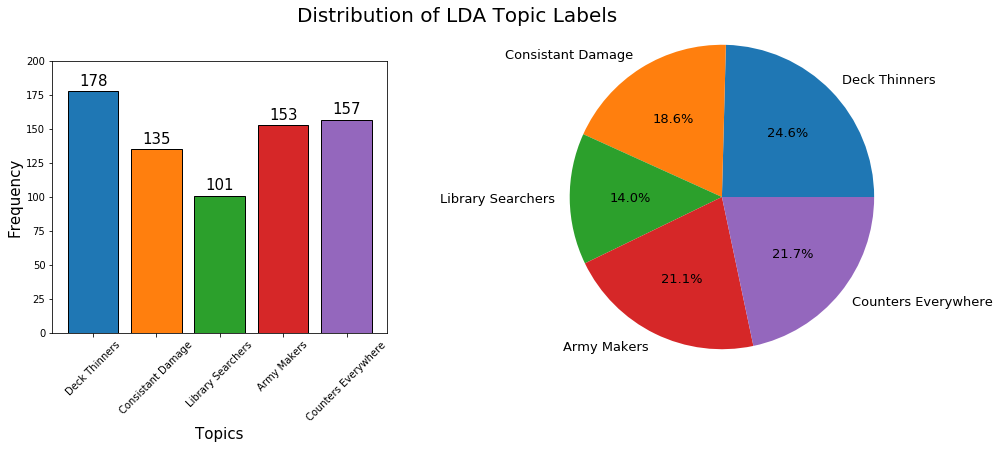

A card is labeled as its most likely topic.


In [235]:
topic_counts = dict.fromkeys(['Deck Thinners','Consistant Damage',
                              'Library Searchers','Army Makers',
                              'Counters Everywhere'],0)
for idx,card in cmdr_topics.iterrows():
    topic_counts[card[:-1].idxmax()] += 1
    
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(topic_counts.keys(),topic_counts.values(),ec='black',lw=1,
          color=[u'#1f77b4',u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd'])
ax[0].set_xticklabels(topic_counts.keys(),rotation=45)
ax[0].set_ylabel('Frequency',size=15)
ax[0].set_xlabel('Topics',size=15)
ax[0].set_ylim([0,200])

for i in ax[0].patches:
    ax[0].text(i.get_x()+.18, i.get_height()+4,
            str(i.get_height()), fontsize=15,
                color='black')


ax[1].pie(topic_counts.values(),radius=1.4,labels=topic_counts.keys(),autopct='%1.1f%%',textprops={'fontsize':13})

plt.subplots_adjust(wspace = 0.5)
fig.suptitle('Distribution of LDA Topic Labels',size=20,y=1.03)
plt.show()
print("A card is labeled as its most likely topic.")

# Visualizations

In [22]:
from wordcloud import WordCloud

In [23]:
topic_words[0]

{0: [{'graveyard': 123.19346849685252},
  {'library': 87.44533772000871},
  {'top': 64.19570418873711},
  {'top library': 40.19596005464112},
  {'dies': 33.699418141246},
  {'attacking': 28.249082664798358},
  {'dealt': 28.19483047697157},
  {'legendary': 24.191828456940296},
  {'planeswalker': 20.18757104215251},
  {'damage': 19.491972024500935}]}

In [236]:
# Plots word clouds and distribution graphs for each topic given the most important words and their weights
def plot_wcs(topic_words):
    topics = ['Deck Thinners','Consistant Damage','Library Searchers','Army Makers','Counters Everywhere']
    c=0
    for topic in topic_words:
        fig, ax = plt.subplots(1,2,figsize=(18,6))
        merged = {}
        for d in list(topic.values())[0]:
            merged.update(d)
        wc = WordCloud(background_color='white').generate_from_frequencies(merged)
        ax[0].set_title(f'Word Cloud',size=25,y=1.1)
        ax[0].imshow(wc,interpolation='bilinear')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].axis('off')
        
        ax[1].set_title('Top 10 TF-IDF Vectorizer',size=25)
        ax[1].bar(merged.keys(),merged.values(),edgecolor='black',linewidth=[1])
        ax[1].set_xticklabels(merged.keys(), rotation=45)
        ax[1].set_ylabel('TF-IDF Score',size=15)
        ax[1].set_xlabel('Tokens',size=15)
        fig.suptitle(topics[c],size=30,y=1.03)
        c += 1

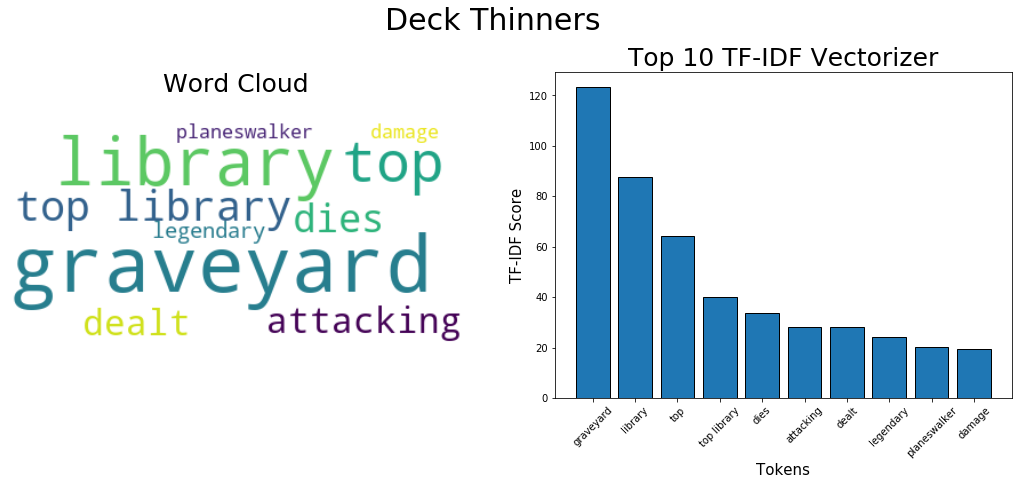

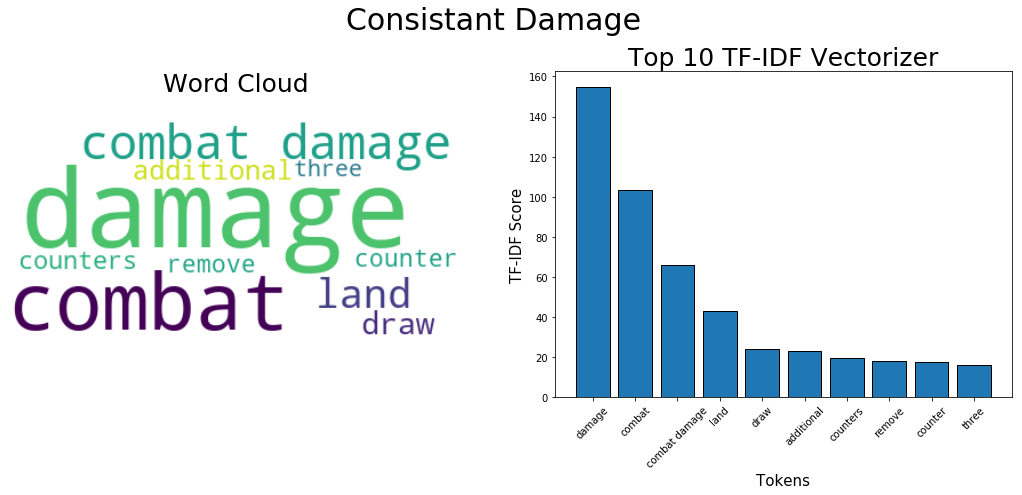

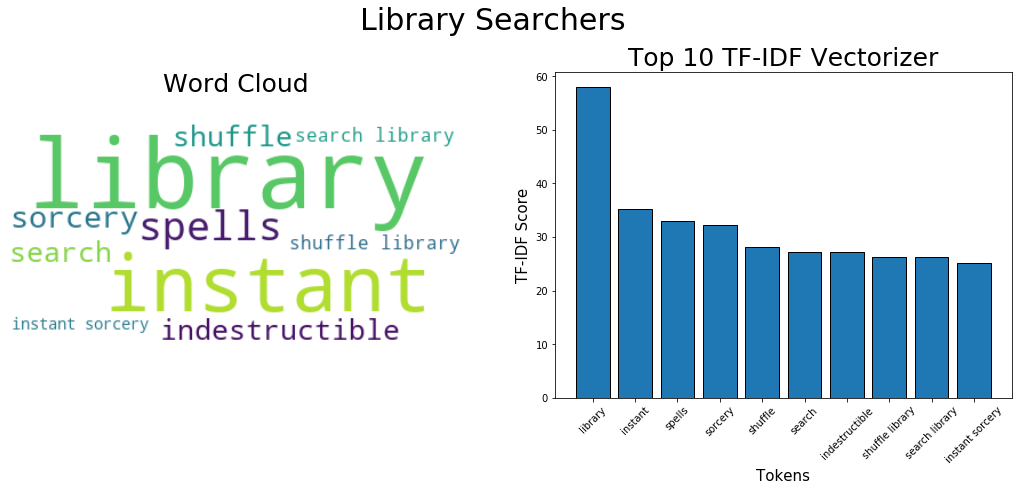

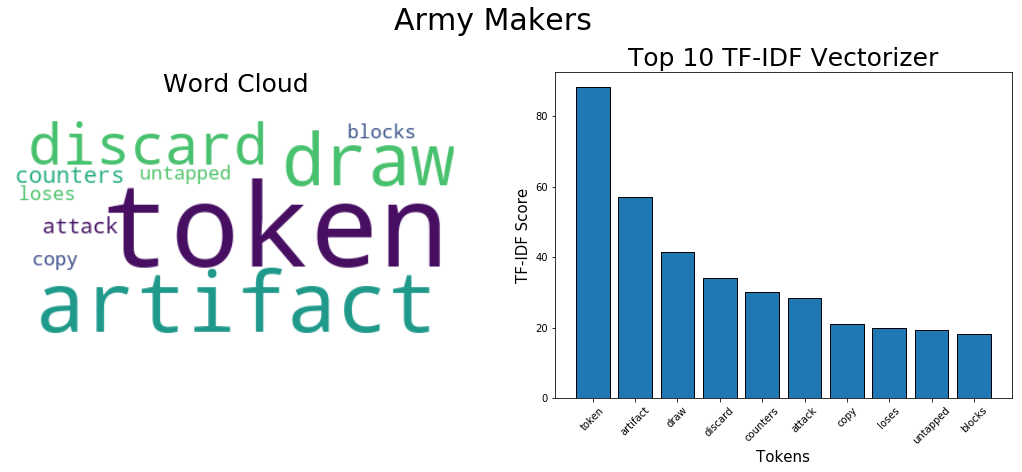

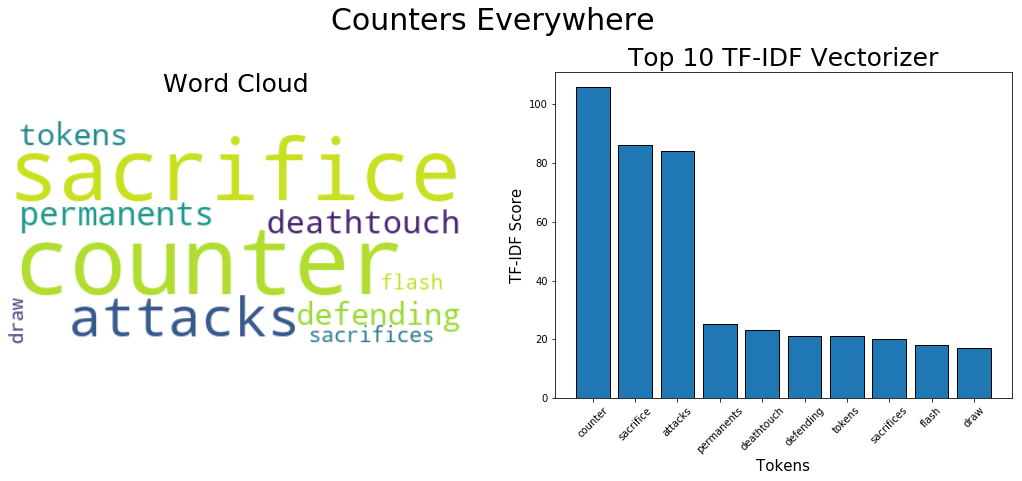

In [237]:
plot_wcs(topic_words)

In [ ]:
# Store the topic scores DataFrame as a JSON
cmdr_topics.to_json(r'Data/tfidf-LDA-commander-topics.json')

# Recommend by topic similarity to another card
**Meant for veterans of magic who are looking for another commander to try**

In [24]:
def recommend_by_commander():
    cmdr_topics = pd.read_json(r'Data/tfidf-LDA-commander-topics.json')
    topics = cmdr_topics.columns[:-1]
    inpt = input("Enter the name of a commander you like: ")
    # Looks for the commander most similar to the input if the input doesn't exist in the dataframe
    if inpt not in cmdr_topics.index.tolist():
        inpt = difflib.get_close_matches(inpt,cmdr_topics.index.tolist(),len(cmdr_topics.index.tolist()),0)[0]
    inpt_row = cmdr_topics.loc[inpt]
    # Calculate a score for each card, with the input having a default score of -1
    # All scores will be a 'distance' from the input row, lowest distance means most similar
    scores = pd.Series(index=cmdr_topics.index)
    scores.loc[inpt] = -1
    for idx, row in cmdr_topics.drop(index=inpt).iterrows():
        scores.loc[idx] = sum([np.absolute(row.loc[topic]-inpt_row.loc[topic]) for topic in topics])
    # Scores are weighted by their popularity/rank in the edhrec database
    scores = (scores*100000)+cmdr_topics['edhrec_rank']
    scores = scores.sort_values().index.tolist()[1:]
    # Display the recommendations in order
    print(f"Showing commanders most similar to: {inpt}")
    offset = 1
    while(1):
        fig, ax = plt.subplots(1,5,figsize=(24,7))
        for idx in range(offset,offset+5):
            ax[idx-offset].set_title(str(idx)+'. '+scores[idx-1],size=15)
            ax[idx-offset].axis('off')
            try:
                response = requests.get(show_card(scores[idx-1]))
                if response.status_code!=200:
                    print(response.status_code,'for',scores[idx-1])
                    ax[idx-offset].imshow(plt.imread(r'placeholder_card.jpeg',format='jpeg'))
                    continue
                ax[idx-offset].imshow(plt.imread(BytesIO(response.content),format='jpg'))
                time.sleep(0.1)
            except TypeError:
                ax[idx-offset].imshow(plt.imread(r'placeholder_card.jpeg',format='jpeg'))
        plt.show()
        move = input("(N)ext or (P)rev? ").lower().strip()
        if move == 'next' or move == 'n':
            offset += 5
        elif move == 'prev' or move == 'p':
            offset -= 5
        else:
            return
        if offset < 0 or offset+5 > len(scores):
            print("End of list.")
            return

Enter the name of a commander you like: k
Showing commanders most similar to: Tor Wauki


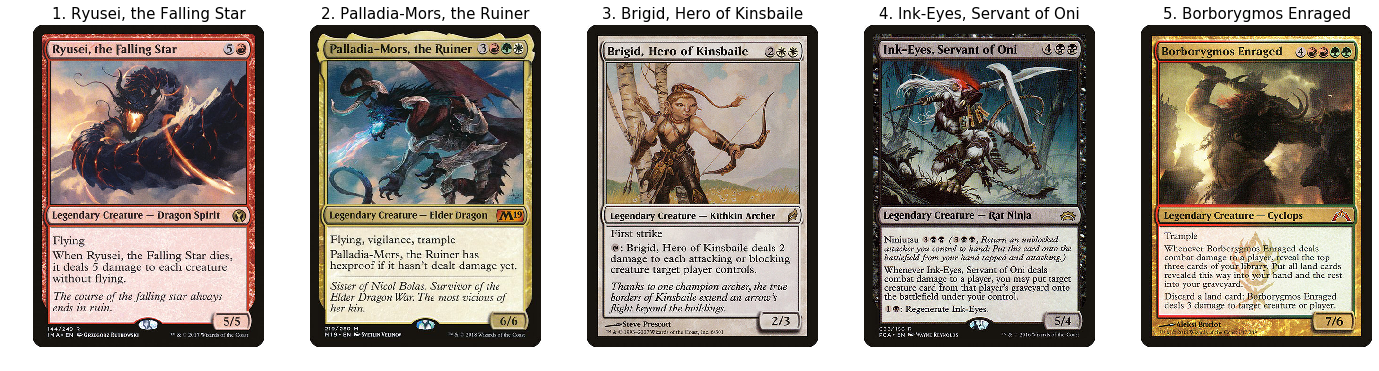

(N)ext or (P)rev? n


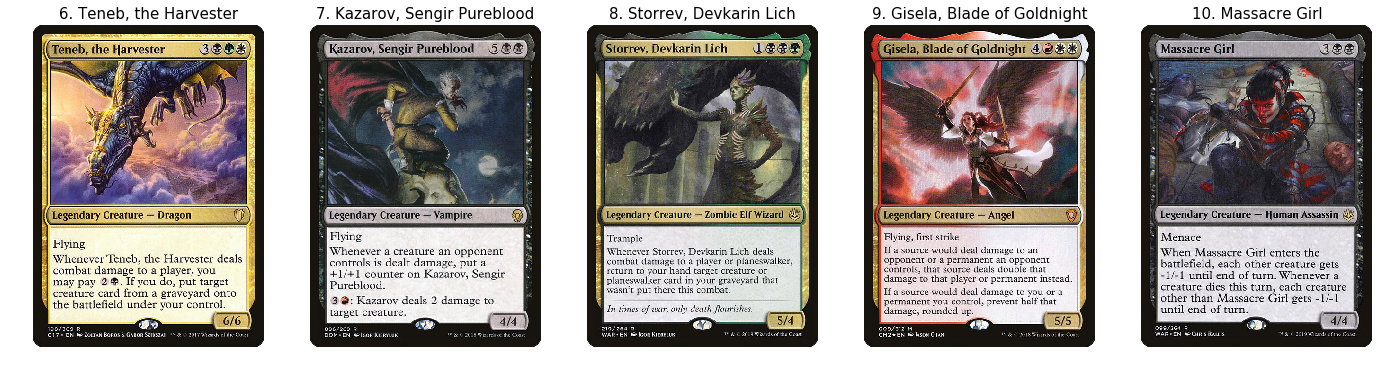

(N)ext or (P)rev? p


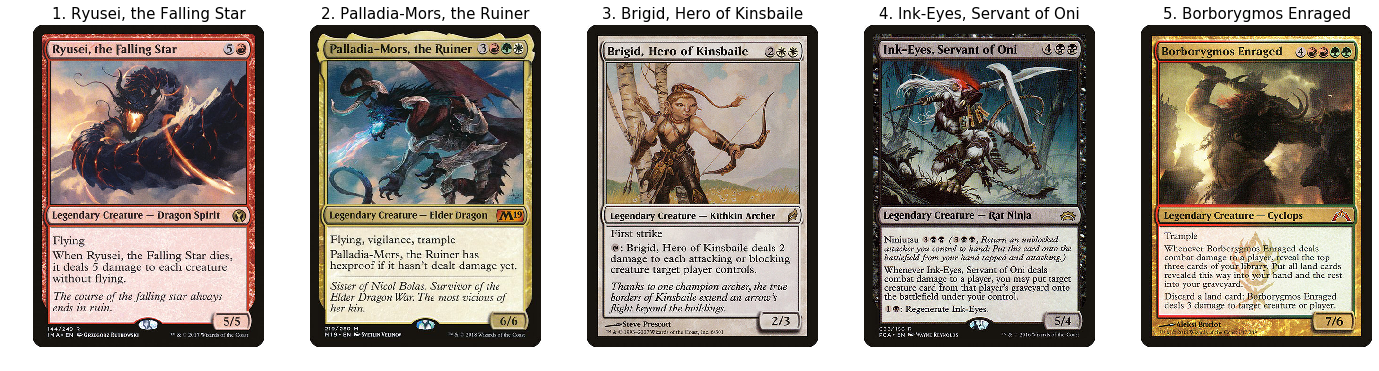

(N)ext or (P)rev? 


In [25]:
recommend_by_commander()

# Recommend by pre-determined topics.
**Meant to give beginners to Magic a place to start**

In [36]:
def recommend_by_topic():
    cmdr_topics = pd.read_json(r'Data/tfidf-LDA-commander-topics.json')
    topics = cmdr_topics.columns[:-1]
    print("Enter number(s) of archtypes you like separated by spaces:")
    for topic_idx in range(len(topics)):
        print(f"\t{topic_idx+1}. {topics[topic_idx]}")
    likes = input().split()
    try:
        likes = list(map(int,likes))
    except:
        print("Non-digit entered.")
        return
    likes = list(set(likes))
    if len(likes)==0:
        return
    if min(likes) < 1 or max(likes) > len(topics):
        print('Entered a number out of range')
        return
    likes = [topics[i-1] for i in likes]
    top_recs = (cmdr_topics[likes]-(1/len(likes))).abs().sum(axis=1)
    top_recs = top_recs[top_recs < 0.4]
    top_recs = (top_recs*100000) + cmdr_topics['edhrec_rank']
    top_recs = top_recs.sort_values().dropna().index.tolist()
    print("--------------------------------------------------------------------")
    print(f"I recommend these {len(top_recs)} commanders for {', '.join(likes)}")
    offset = 1
    while(1):
        fig,ax = plt.subplots(1,5,figsize=(24,7))
        for idx in range(offset,offset+5):
            ax[idx-offset].set_title(str(idx)+'. '+top_recs[idx-1],size=15)
            ax[idx-offset].axis('off')
            try:
                response = requests.get(show_card(top_recs[idx-1]))
                if response.status_code!=200:
                    print(response.status_code,'for',top_recs[idx-1])
                    ax[idx-offset].imshow(plt.imread(r'placeholder_card.jpeg',format='jpeg'))
                    continue
                ax[idx-offset].imshow(plt.imread(BytesIO(response.content),format='jpg'))
                time.sleep(0.1)
            except TypeError:
                ax[idx-offset].imshow(plt.imread(r'placeholder_card.jpeg',format='jpeg'))
        plt.show()
        move = input("(N)ext or (P)rev? ").lower().strip()
        if move == 'next' or move == 'n':
            offset += 5
        elif move == 'prev' or move == 'p':
            offset -= 5
        else:
            return
        if offset < 0 or offset+5 > len(top_recs):
            print("End of list.")
            return
    
#     scores = cmdr_topics[likes].diff(axis=1).fillna(0).abs().sum(axis=1)
#     print(scores.sort_values())

Enter number(s) of archtypes you like separated by spaces:
	1. Deck Thinners
	2. Consistant Damage
	3. Library Searchers
	4. Army Makers
	5. Counters Everywhere
1
--------------------------------------------------------------------
I recommend these 51 commanders for Deck Thinners


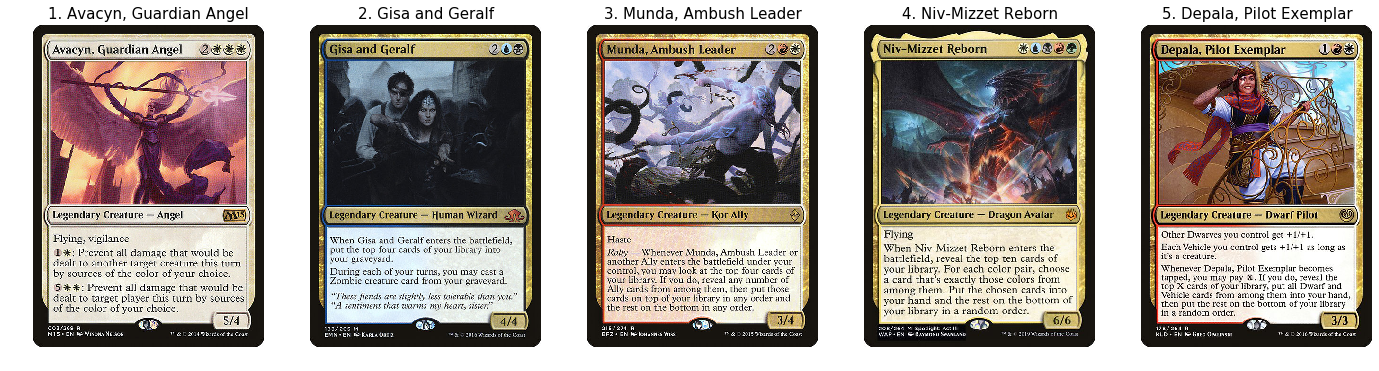

(N)ext or (P)rev? 


In [35]:
recommend_by_topic()

# Wrap both recommdendation systems into a single function

In [41]:
def recommender():
    print("How would you like to be recommended a new Commander? (Enter the number)")
    print("\t1. There's a commander I liked playing before!")
    print("\t2. I want some general playstyles to chooose from.")
    print("\t3. WHAT IS COMMANDER???")
    while(1):
        how = input().strip()
        if how == '':
            return
        try:
            how = int(how)
            if how == 3:
                print("""
-----------------------------------------------------------------------------------
   "Commander is an exciting, unique way to play Magic that is all about awesome 
    legendary creatures, big plays, and battling your friends in epic multiplayer 
    games! In Commander, each player chooses a legendary creature as the commander 
    of their deck. They then play with a 99-card deck that contains only cards of 
    their commander's colors. Also, other than basic lands, each deck can only use 
    one copy of any card. During the game, you can cast your commander multiple 
    times, meaning your favorite Legendary Creature can come back again and again 
    to lead the charge as you battle for victory!"
        Taken from Wizards of the Coast site.
-----------------------------------------------------------------------------------
""")
            elif how in [1,2]:
                break
            else:
                print('Enter 1, 2, or 3')
        except ValueError:
            print('Enter 1, 2, or 3.')
    if how == 1:
        recommend_by_commander()
    elif how == 2:
        recommend_by_topic()

How would you like to be recommended a new Commander? (Enter the number)
	1. There's a commander I liked playing before!
	2. I want some general playstyles to chooose from.
	3. WHAT IS COMMANDER???
3

-----------------------------------------------------------------------------------
   "Commander is an exciting, unique way to play Magic that is all about awesome 
    legendary creatures, big plays, and battling your friends in epic multiplayer 
    games! In Commander, each player chooses a legendary creature as the commander 
    of their deck. They then play with a 99-card deck that contains only cards of 
    their commander's colors. Also, other than basic lands, each deck can only use 
    one copy of any card. During the game, you can cast your commander multiple 
    times, meaning your favorite Legendary Creature can come back again and again 
    to lead the charge as you battle for victory!"
        Taken from Wizards of the Coast site.
--------------------------------------

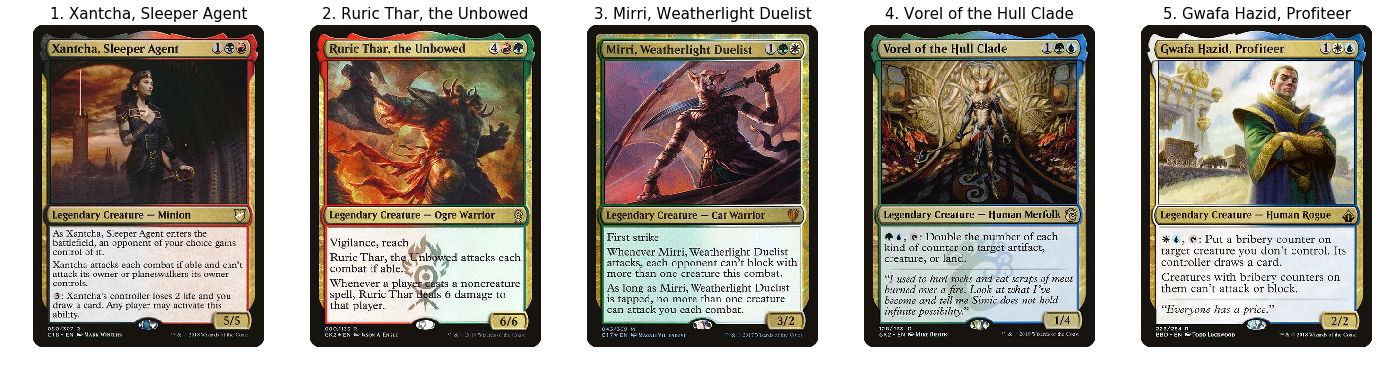

(N)ext or (P)rev? 


In [42]:
recommender()